In [2]:
import pandas as pd
import numpy as np
from loaders import *
import matplotlib.pyplot as plt

In [3]:
ARCH_CONFIG = {'pe_meshX': 4, 'pe_meshY': 4}

# Baseline config (Control group)
config_example = dict(
    DRAM_factor_N=50,
    DRAM_factor_M=2,
    DRAM_factor_C=4,
    global_buffer_factor_N=1,
    global_buffer_factor_M=4,
    global_buffer_factor_C=1,
    PE_spatial_factor_N=1,
    PE_spatial_factor_M=1,
    PE_spatial_factor_C=1,
    scratchpad_factor_N=1,
     **ARCH_CONFIG,
)


In [4]:
# Data Parallelism will split the N (batch rank) along the PE_spatial factor.
# ie. in this case there are 2 GPUs that are being delivered 25 data points to process.
DP_example = config_example.copy()
DP_example.update({
    'DRAM_factor_N': 25,
    'PE_spatial_factor_N': 2,
    'PE_spatial_factor_M': 1,
    'PE_spatial_factor_C': 1,
})

In [10]:
# Tensor Parallelism will split up the filter weights
# ie. the M RxS filters will be partitioned so each GPU of the 4 GPUs here will get a filter
# to work with.
TP_example = config_example.copy()
TP_example.update({
    'global_buffer_factor_M': 1,
    'PE_spatial_factor_N': 1,
    'PE_spatial_factor_M': 4, # 
    'PE_spatial_factor_C': 1,
})

configs = {
    'Base': config_example,
    'DP': DP_example,
    'TP': TP_example,
}


In [11]:
# Copied from conv2.yaml
# instance:
#     C: 4  # inchn
#     M: 8  # outchn
#     R: 5   # filter height
#     S: 5   # filter width
#     P: 28  # ofmap height
#     Q: 28  # ofmap width
#     N: 50   # batch size
C, M, R, S, P, Q, N = 4, 8, 5, 5, 28, 28, 50
energy_per_hop = 2.0 # 2 uJ per hop


to_run = list(configs.keys())
results = []

config_names_results = []
energy_results = []
cycle_results = []

C, M, R, S, P, Q, N = 4, 8, 5, 5, 28, 28, 50
total_MACs = C * M * R * S * P * Q * N

throughput_results = []

for i, config_name in enumerate(to_run):
    config = configs[config_name]
    result = run_timeloop_model(
        config,
        architecture='designs/system/arch.yaml',
        mapping='designs/system/map.yaml',
        problem='layer_shapes/conv2.yaml'
    )
    stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()

    # Parse energy and cycles
    lines = stats.split('\n')
    energy = float([l for l in lines if 'Energy:' in l][0].split(' ', 2)[1])
    cycles = int([l for l in lines if 'Cycles:' in l][0].split(' ', 1)[1])
    num_hops = next((int(l.split(':')[1].strip()) for l in lines if 'Num-hops' in l), None)

    mapping = result.mapping

    energy_line = [l for l in lines if 'Energy:' in l][0]
    # print("Energy line:", energy_line)

    print(energy, cycles)
    config_names_results.append(config_name)
    energy_results.append(energy)
    cycle_results.append(cycles)
    throughput = total_MACs / cycles
    throughput_results.append(throughput)


[INFO] 2025-04-15 22:28:57,594 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


495.6 31360000
[INFO] 2025-04-15 22:29:01,846 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


492.91 15680000
[INFO] 2025-04-15 22:29:05,767 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


435.87 7840000


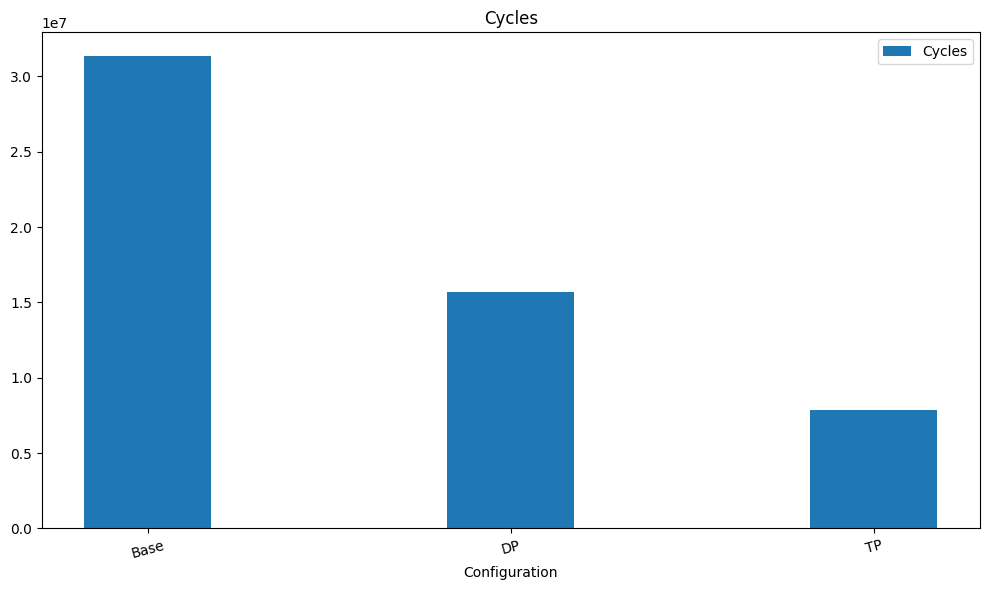

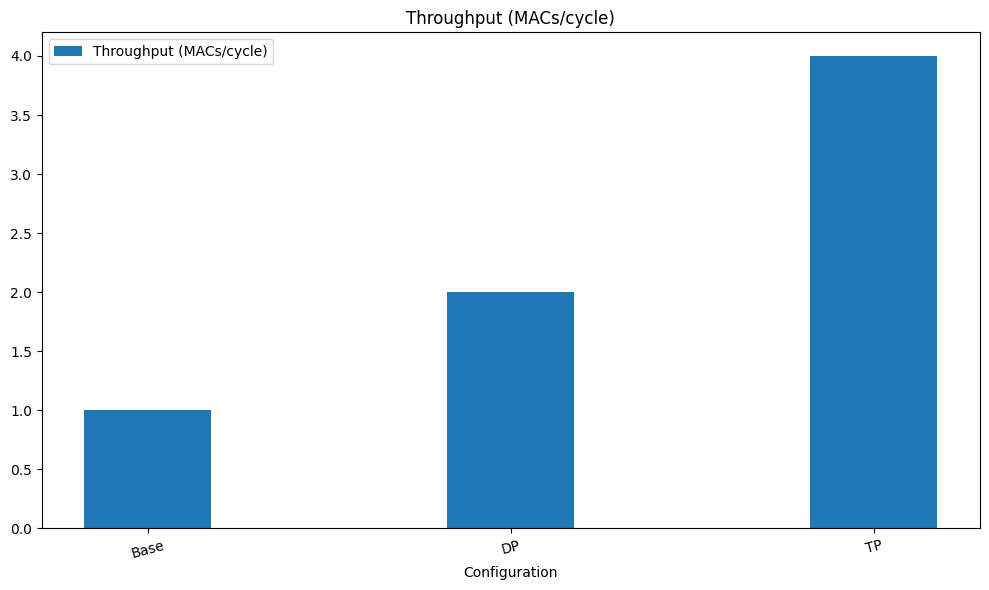

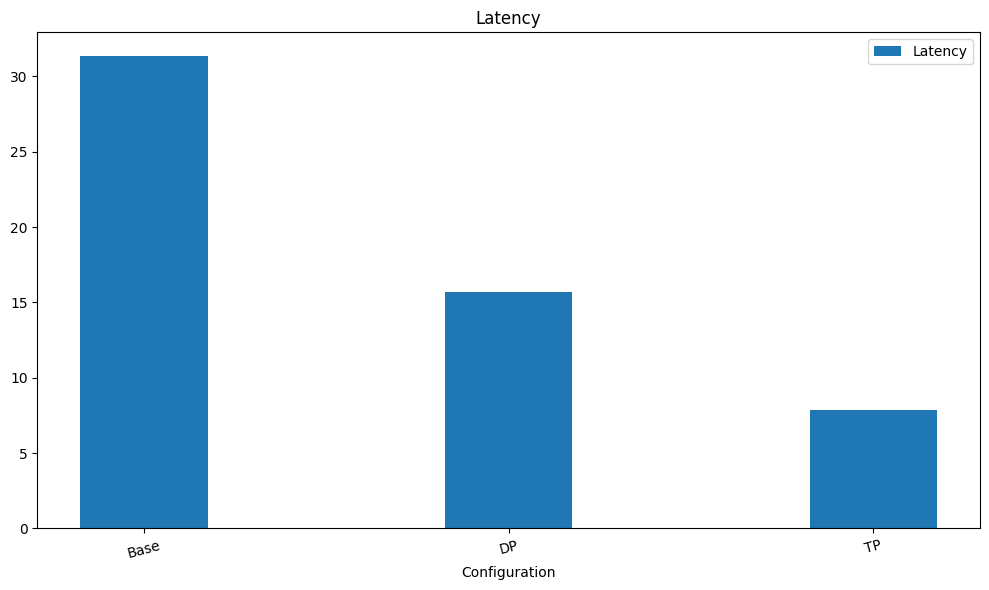

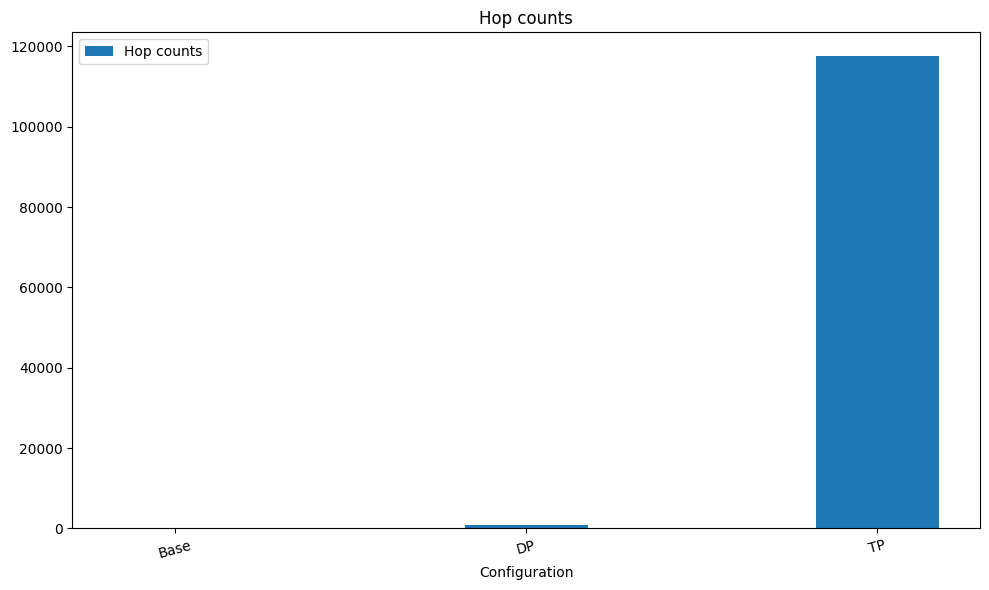

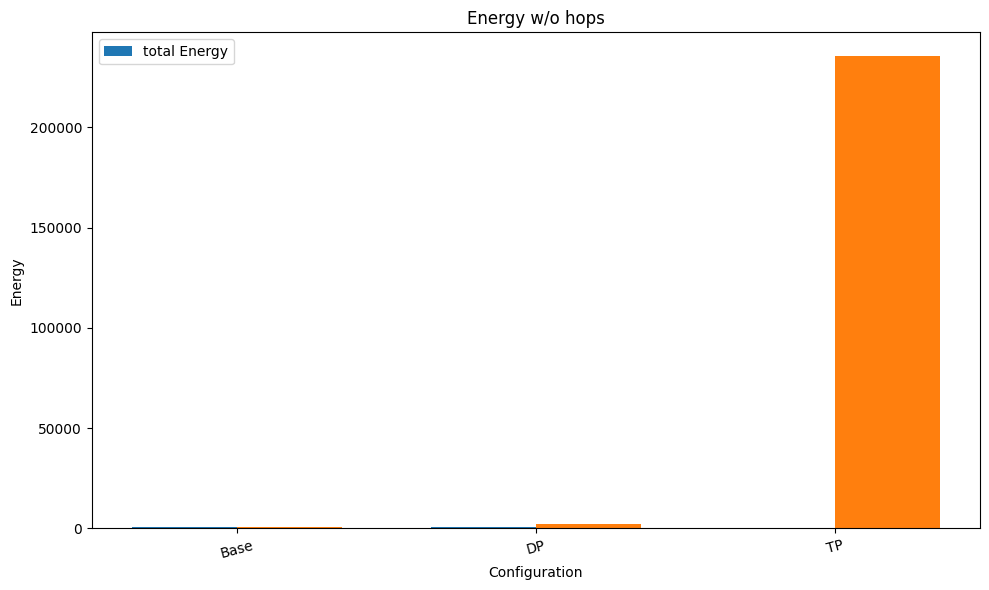

[31360000, 15680000, 7840000]
[1.0, 2.0, 4.0]
[31.36, 15.68, 7.84]
[0, 800, 117600]
[495.6, 2092.91, 235635.87]


In [12]:
def plot_results(labels, data, title):
    bar_width = 0.35
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, data, bar_width, label=title)

    ax.set_xlabel('Configuration')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_double_results(labels, data1, data2, title, label1='', label2=''):
    bar_width = 0.35
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - bar_width/2, data1, bar_width, label=label1)
    ax.bar(x + bar_width/2, data2, bar_width, label=label2)

    ax.set_xlabel('Configuration')
    ax.set_ylabel('Energy')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)
    ax.legend()

    plt.tight_layout()
    plt.show()

def estimate_hops(config, N, M, C, R, S, P, Q):
    pe_N = config.get('PE_spatial_factor_N', 1)
    pe_M = config.get('PE_spatial_factor_M', 1)
    pe_C = config.get('PE_spatial_factor_C', 1)

    # Total PEs = product of spatial factors
    total_PEs = pe_N * pe_M * pe_C

    # Tensor Parallelism: Reduce partial sums of activations
    # we have our PEs spread across pe_M PEs. This will require pe_M - 1 hops since
    # each PE needs to communicate with each other
    comm_count = (pe_M - 1)
    if pe_M > 1:
        total_outputs = N * P * Q
        return total_outputs * comm_count

    # Data Parallelism: Reduce gradients across replicas
    if pe_N > 1 and pe_M == 1 and pe_C == 1:
        num_weights = M * C * R * S
        return num_weights * (pe_N - 1)
    return 0

def estimate_latency(cycles, frequency_hz=1e9): # Use 1 GHz for frequency
    latency_seconds = cycles / frequency_hz
    latency_ms = latency_seconds * 1e3
    return latency_ms

base_hop = estimate_hops(config_example, N, M, C, R, S, P, Q)
DP_hop = estimate_hops(DP_example, N, M, C, R, S, P, Q)
TP_hop = estimate_hops(TP_example, N, M, C, R, S, P, Q)

hop_results = [base_hop, DP_hop, TP_hop]

# Total energy is the energy from the model + the estimated energy from network hops
tot_energy = []
for i in range(len(energy_results)):
    tot_energy.append(energy_results[i] + hop_results[i]  * energy_per_hop)

latency_results = []
for cycles in cycle_results:
    latency_results.append(estimate_latency(cycles))
    
plot_results(config_names_results, cycle_results, 'Cycles')
plot_results(config_names_results, throughput_results, 'Throughput (MACs/cycle)')
plot_results(config_names_results, latency_results, 'Latency')
plot_results(config_names_results, hop_results, 'Hop counts')

plot_double_results(config_names_results, energy_results, tot_energy, 'Energy w/o hops', 'total Energy')

print(cycle_results)
print(throughput_results)
print(latency_results)
print(hop_results)
print(tot_energy)

In [13]:
# It looks like the base line configuration uses the least amount of total energy as well
# as has the highest latency and lowest throughput. This is in line with this model since it is
# only 1 GPU with no need for network communication.

# Energy is highest for TP which makes sense since we need to sync tensors at end of each layer
# while for DP it's only at the ened of each step for the gradients.

# TP also leads to the highest throughput but at the expense of the highest amount of energy.

